# Api contaminación 2022-2024

## ETL: EXTRACCION

In [81]:
import requests
from datetime import datetime
from geopy.geocoders import Nominatim
import pandas as pd

### Definición de la función de extracción

In [82]:
def extract_data(api_key, zones_names, start_date, end_date):
    geolocator = Nominatim(user_agent="my_geocoder", timeout=10)
    start_date_datetime = datetime.strptime(start_date, "%Y-%m-%d")
    start_date_unix = int(start_date_datetime.timestamp())
    end_date_datetime = datetime.strptime(end_date, "%Y-%m-%d")
    end_date_unix = int(end_date_datetime.timestamp())
    dfs = []

    for zone in zones_names:
        location = geolocator.geocode(f"{zone}, New York, USA")
        if location:
            lat, lon = location.latitude, location.longitude

            url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start_date_unix}&end={end_date_unix}&appid={api_key}"
            response = requests.get(url)
            data = response.json()

            clean_data = {'date': [], 'co': [], 'pm2.5': [], 'pm10': [], 'zone': []}
            for entry in data['list']:
                clean_data['date'].append(datetime.fromtimestamp(entry['dt']).strftime('%Y-%m-%d %H:%M:%S'))
                clean_data['co'].append(entry['components']['co'])
                clean_data['pm2.5'].append(entry['components']['pm2_5'])
                clean_data['pm10'].append(entry['components']['pm10'])
                clean_data['zone'].append(zone)

            df = pd.DataFrame(clean_data)
            dfs.append(df)
        else:
            print(f"No se pudo encontrar la ubicación para {zone}")

    df_final = pd.concat(dfs, ignore_index=True)
    return df_final

# Parámetros de la API
api_key = 'e49a90e730e178434b65ddc9689cbf9d'
zones_names = [
    'Upper East Side, Manhattan', 'Williamsburg, Brooklyn', 'Astoria, Queens', 
    'Riverdale, Bronx', 'St. George, Staten Island'
]
start_date = '2020-11-27'
end_date = datetime.now().date().strftime("%Y-%m-%d")


### Uso de la función de extracción

In [83]:
# Uso de la función de extracción
df_final = extract_data(api_key, zones_names, start_date, end_date)
print(df_final)

                       date       co  pm2.5   pm10                        zone
0       2020-11-27 00:00:00   547.41  14.85  22.09  Upper East Side, Manhattan
1       2020-11-27 01:00:00   520.71  14.19  20.84  Upper East Side, Manhattan
2       2020-11-27 02:00:00   514.03  14.82  21.53  Upper East Side, Manhattan
3       2020-11-27 03:00:00   534.06  16.28  23.39  Upper East Side, Manhattan
4       2020-11-27 04:00:00   554.09  17.11  24.69  Upper East Side, Manhattan
...                     ...      ...    ...    ...                         ...
135120  2024-01-08 20:00:00  1268.39  50.84  82.51   St. George, Staten Island
135121  2024-01-08 21:00:00  1295.09  55.18  88.72   St. George, Staten Island
135122  2024-01-08 22:00:00  1295.09  56.78  90.31   St. George, Staten Island
135123  2024-01-08 23:00:00  1268.39  55.63  86.37   St. George, Staten Island
135124  2024-01-09 00:00:00  1281.74  57.36  85.76   St. George, Staten Island

[135125 rows x 5 columns]


In [84]:
df_final

,date,co,pm2.5,pm10,zone
0,2020-11-27 00:00:00,547.41,14.85,22.09,"Upper East Side, Manhattan"
1,2020-11-27 01:00:00,520.71,14.19,20.84,"Upper East Side, Manhattan"
2,2020-11-27 02:00:00,514.03,14.82,21.53,"Upper East Side, Manhattan"
3,2020-11-27 03:00:00,534.06,16.28,23.39,"Upper East Side, Manhattan"
4,2020-11-27 04:00:00,554.09,17.11,24.69,"Upper East Side, Manhattan"
...,...,...,...,...,...
135120,2024-01-08 20:00:00,1268.39,50.84,82.51,"St. George, Staten Island"
135121,2024-01-08 21:00:00,1295.09,55.18,88.72,"St. George, Staten Island"
135122,2024-01-08 22:00:00,1295.09,56.78,90.31,"St. George, Staten Island"
135123,2024-01-08 23:00:00,1268.39,55.63,86.37,"St. George, Staten Island"


## ETL: Transformación

### Definición de la función de transformación 

transformacion

In [85]:
def transform_data(df):
    # Asegurarse de que 'co' y 'pm2.5' sean numéricos, coerción de errores a NaN
    df['co'] = pd.to_numeric(df['co'], errors='coerce')
    df['pm2.5'] = pd.to_numeric(df['pm2.5'], errors='coerce')

    # Mapeo de los boroughs
    borough_mapping = {
        'Upper East Side, Manhattan': 'Manhattan',
        'Williamsburg, Brooklyn': 'Brooklyn',
        'Astoria, Queens': 'Queens',
        'Riverdale, Bronx': 'Bronx',
        'St. George, Staten Island': 'Staten Island',
       
    }

    df['borough'] = df['zone'].map(borough_mapping)
    df.drop('zone', axis=1, inplace=True)

    return df

### Definición de la función de agregación 

In [86]:
# Agregacion mensual
def aggregate_monthly_with_boroughs(df):
    # Asegurarse de que 'date' sea de tipo DateTime
    df['date'] = pd.to_datetime(df['date'])

    # Establecer 'date' como el índice del DataFrame
    df.set_index('date', inplace=True)

    # agrupar por mes, promediando valores para cada borough
    df_monthly = df.groupby(['borough', pd.Grouper(freq='MS')])[['co', 'pm2.5', 'pm10']].mean().reset_index()

    return df_monthly

Aplicacion de las funciones

In [87]:
# Transformación de datos
df_final_transformed = transform_data(df_final)



In [88]:
# Agregación mensual
df_monthly = aggregate_monthly_with_boroughs(df_final_transformed)


In [89]:
df_monthly

,borough,date,co,pm2.5,pm10
0,Bronx,2020-11-01,391.677917,8.598438,12.514271
1,Bronx,2020-12-01,424.610941,13.278038,17.505645
2,Bronx,2021-01-01,369.432056,9.043153,12.341528
3,Bronx,2021-02-01,393.833452,10.884092,14.132604
4,Bronx,2021-03-01,397.667823,12.969261,17.174234
...,...,...,...,...,...
190,Staten Island,2023-09-01,432.756221,14.821537,19.110029
191,Staten Island,2023-10-01,538.283911,18.375228,24.675161
192,Staten Island,2023-11-01,486.428083,13.318458,18.734139
193,Staten Island,2023-12-01,685.508280,27.121169,35.332097


### Carga de los datos. En este caso la exportación a csv

In [90]:
#df_monthly.to_csv("df_monthly-emisions-2021-2024.csv")


# Modelo 

### Definición de la función 

In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns

def fit_sarima_and_forecast(df, column, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    # Ajustar el modelo SARIMA
    sarima_model = SARIMAX(df[column], 
                           order=order, 
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_result = sarima_model.fit(disp=False)
    
    # Realizar predicciones para los próximos 12 meses
    prediction = sarima_result.get_forecast(steps=12)
    prediction_ci = prediction.conf_int()
    return prediction.predicted_mean, prediction_ci

def generate_forecast_plots(df, boroughs, column):
    for borough in boroughs:
        df_borough = df[df['borough'] == borough].set_index('date')
        predicted_mean, prediction_ci = fit_sarima_and_forecast(df_borough, column)

        plt.figure(figsize=(10, 5))
        sns.lineplot(data=df_borough, x=df_borough.index, y=column, label='Observed')
        sns.lineplot(x=predicted_mean.index, y=predicted_mean, label='Forecast')
        plt.fill_between(prediction_ci.index, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1], color='k', alpha=0.1)
        plt.title(f'Forecast for {borough} - {column}')
        plt.xlabel('Date')
        plt.ylabel(f'{column} Level')
        plt.legend()
        plt.show()




## Aplicación Para cada distrito "CO"

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


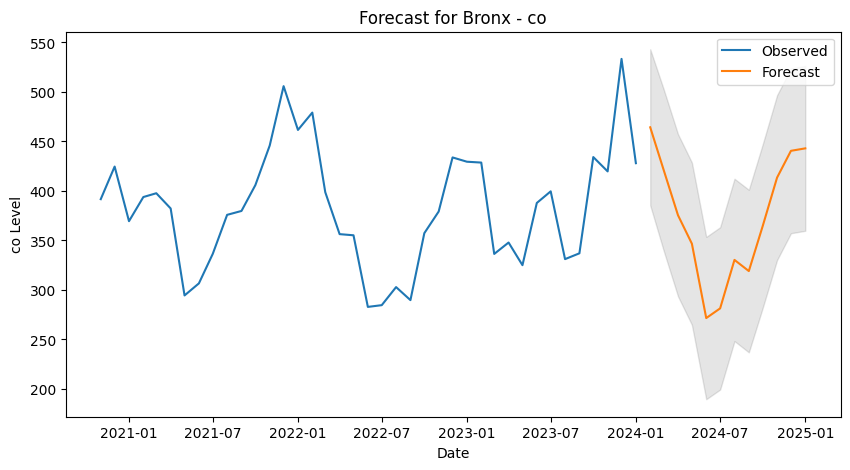

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


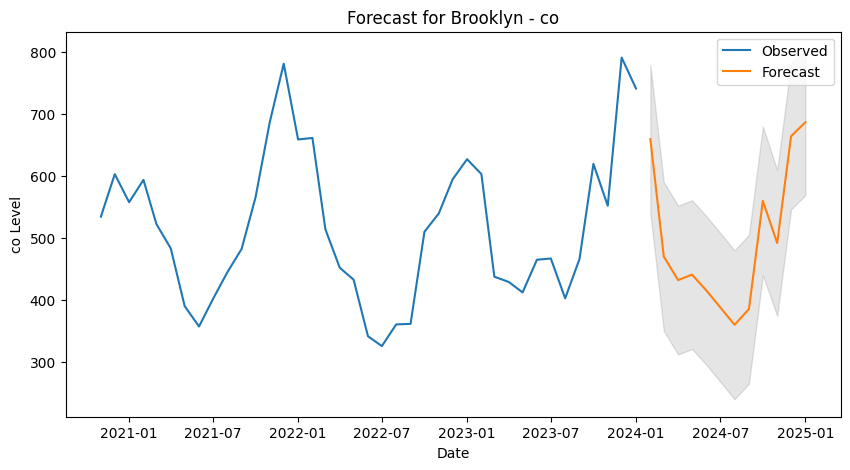

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


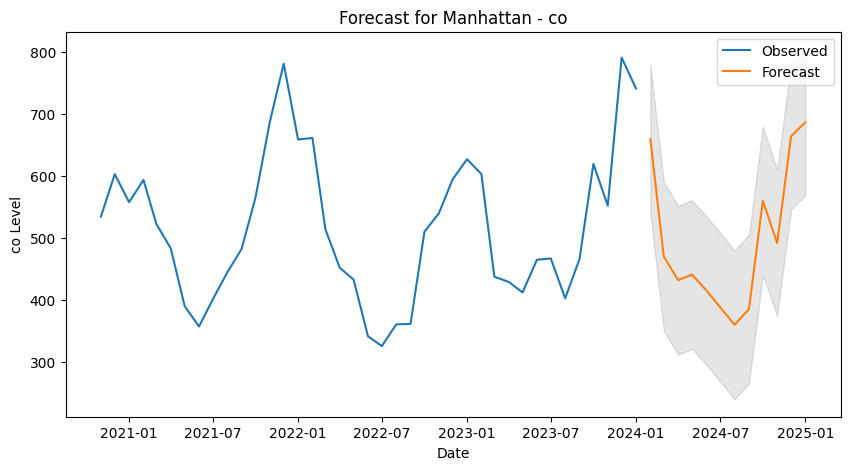

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


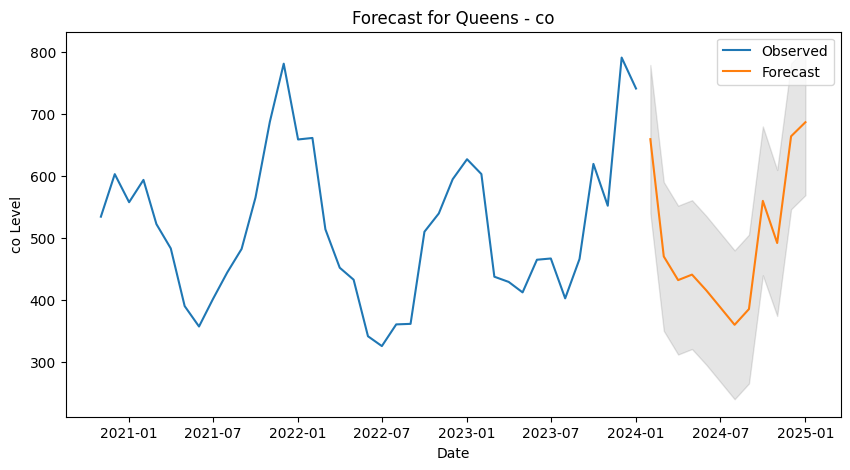

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


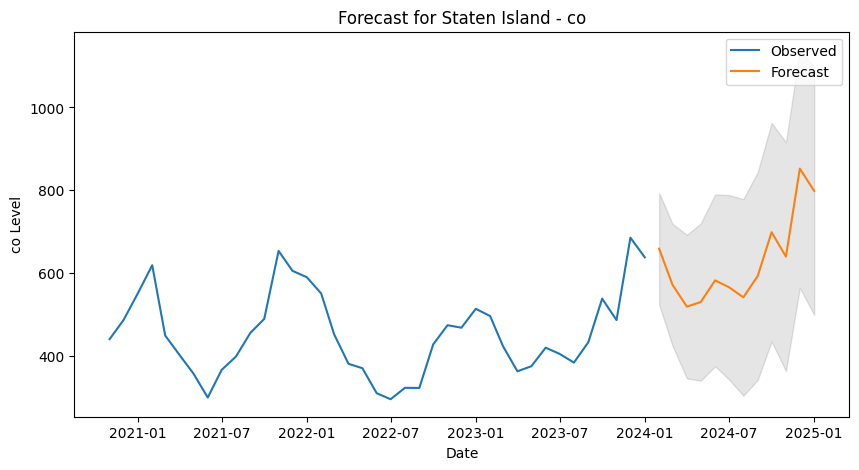

In [92]:
# Aplicar la función de modelado y generar gráficos
boroughs = df_monthly['borough'].unique()
column_to_forecast = 'co'  # Se puede cambiar esto a 'pm2.5' o 'pm10' según sea necesario
generate_forecast_plots(df_monthly, boroughs, column_to_forecast)

## Para cada distrito pm2.5

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


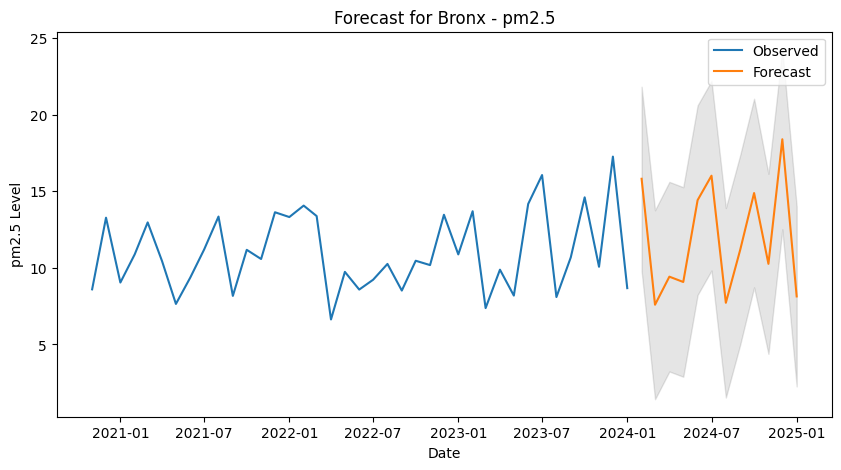

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


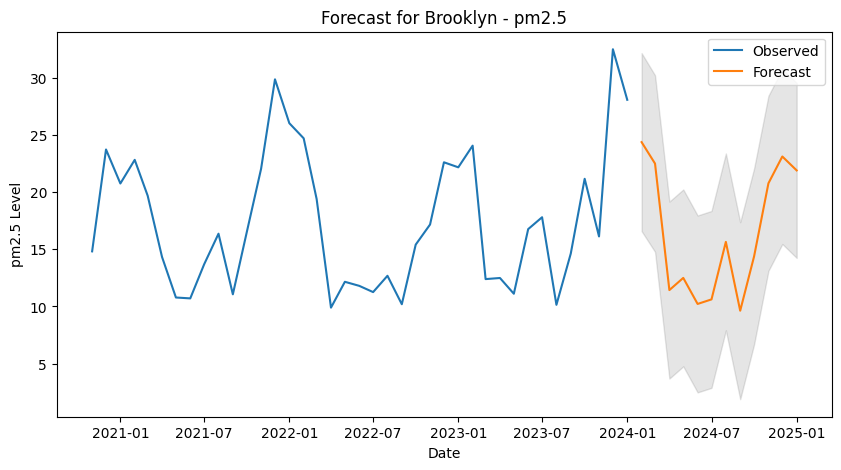

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


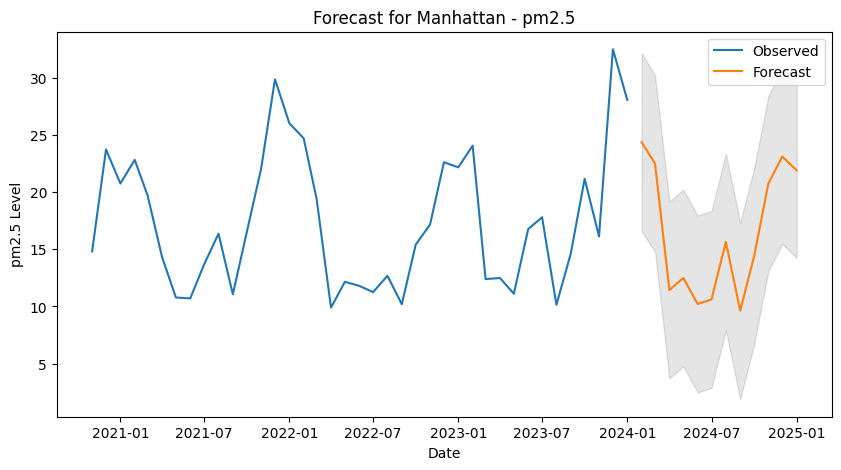

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


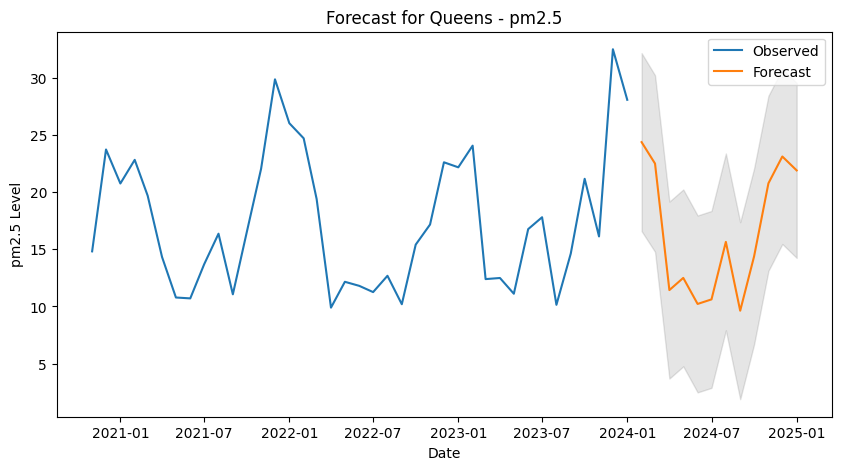

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


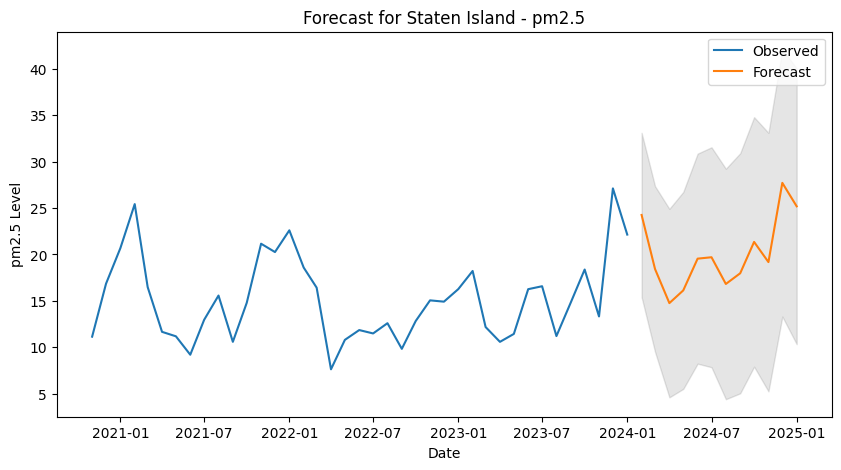

In [93]:
# Aplicar la función de modelado y generar gráficos
boroughs = df_monthly['borough'].unique()
column_to_forecast = 'pm2.5'  # Se puede cambiar esto a 'pm2.5' o 'pm10' según sea necesario
generate_forecast_plots(df_monthly, boroughs, column_to_forecast)


## Para cada distrito pm10

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


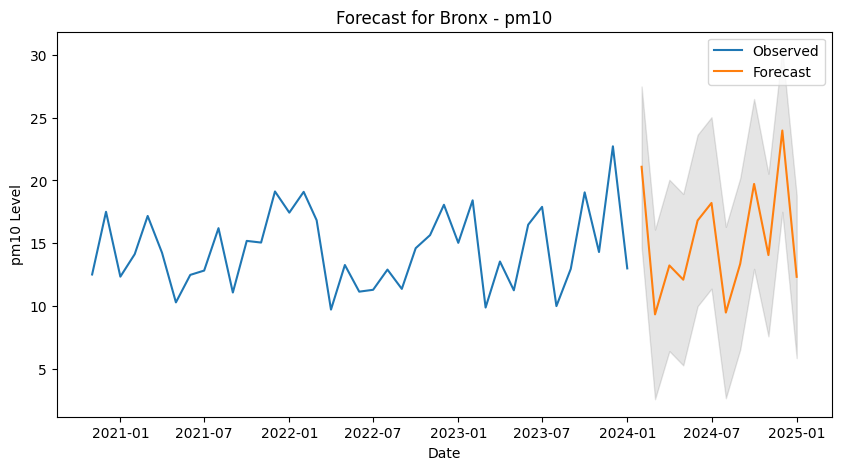

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


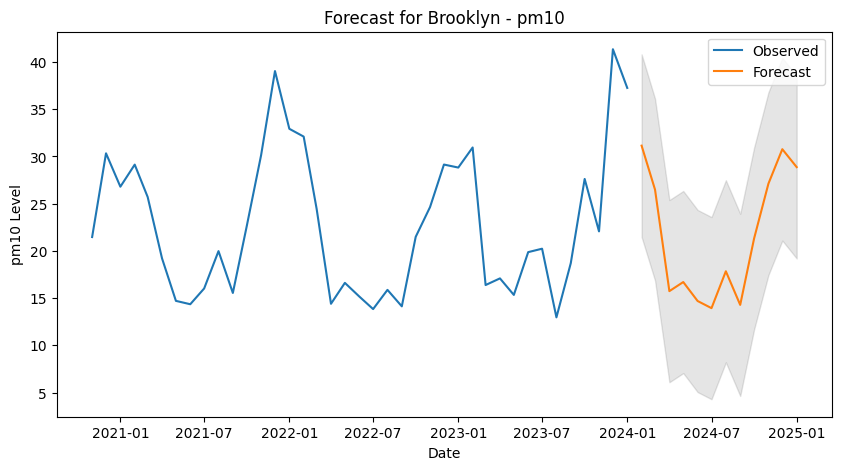

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


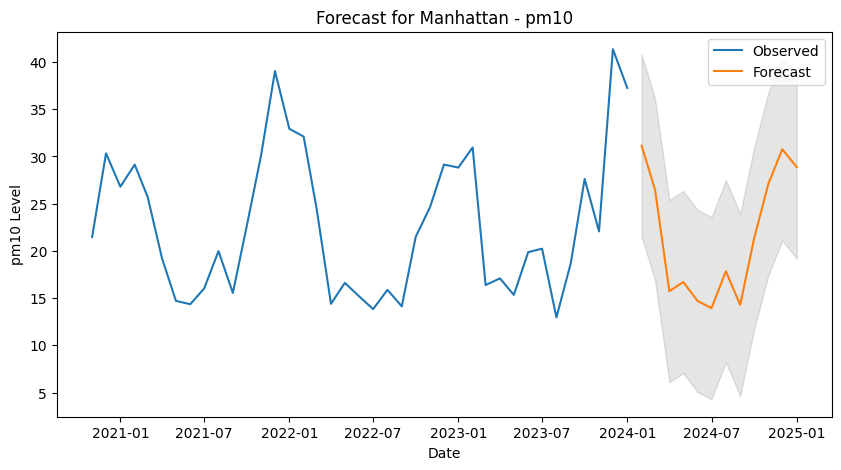

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


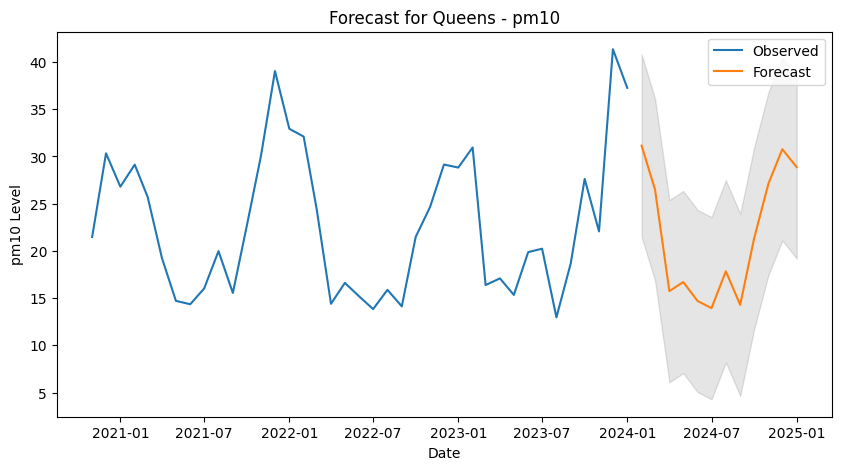

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


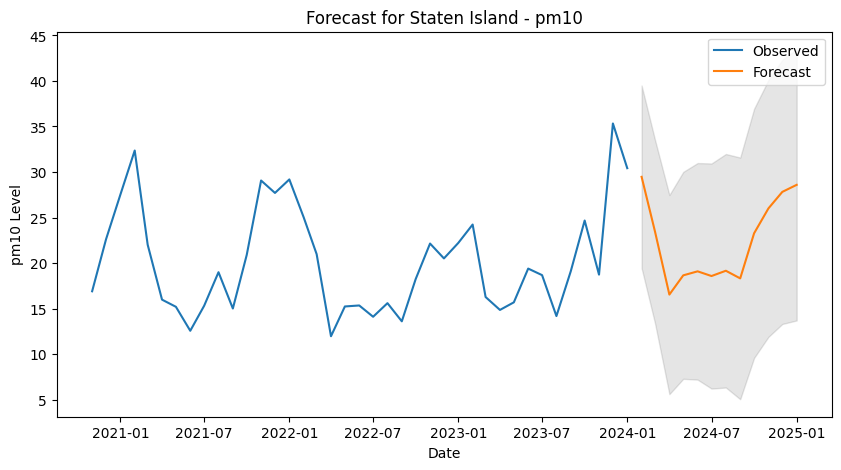

In [94]:
# Aplicar la función de modelado y generar gráficos
boroughs = df_monthly['borough'].unique()
column_to_forecast = 'pm10'  # Se puede cambiar esto a 'pm2.5' o 'pm10' según sea necesario
generate_forecast_plots(df_monthly, boroughs, column_to_forecast)


## Predicción solo para new york CO

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


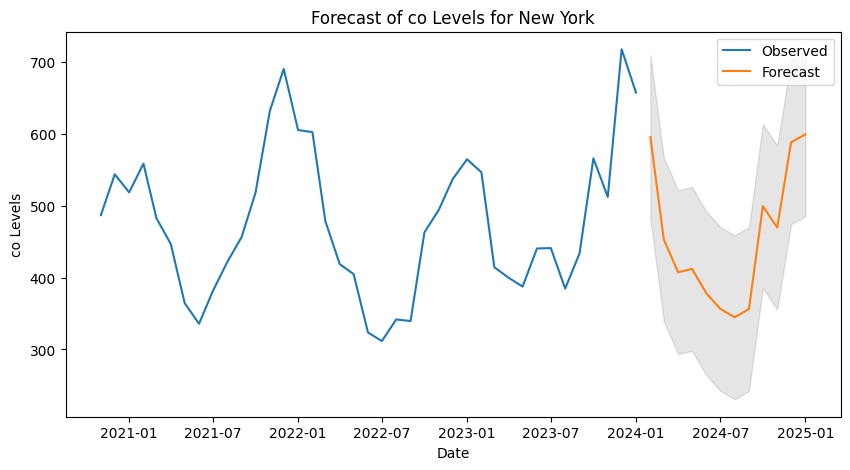

In [95]:
def forecast_new_york(df, column, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    # Agrupar por fecha y calcular la media para Nueva York en su conjunto
    df_ny = df.groupby('date')[column].mean()

    # Ajustar el modelo SARIMA a los datos de Nueva York
    sarima_model = SARIMAX(df_ny, 
                           order=order, 
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_result = sarima_model.fit(disp=False)

    # Realizar predicciones para los próximos 12 meses
    prediction = sarima_result.get_forecast(steps=12)
    prediction_ci = prediction.conf_int()

    # Plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_ny, label='Observed')
    sns.lineplot(x=prediction.predicted_mean.index, y=prediction.predicted_mean, label='Forecast')
    plt.fill_between(prediction_ci.index, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1], color='k', alpha=0.1)
    plt.title(f'Forecast of {column} Levels for New York')
    plt.xlabel('Date')
    plt.ylabel(f'{column} Levels')
    plt.legend()
    plt.show()

# Ejecución de la función
column_to_forecast = 'co'  # se puede cambiar a 'pm2.5' o 'pm10' según sea necesario
forecast_new_york(df_monthly, column_to_forecast)


## Para new york pm 2.5

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


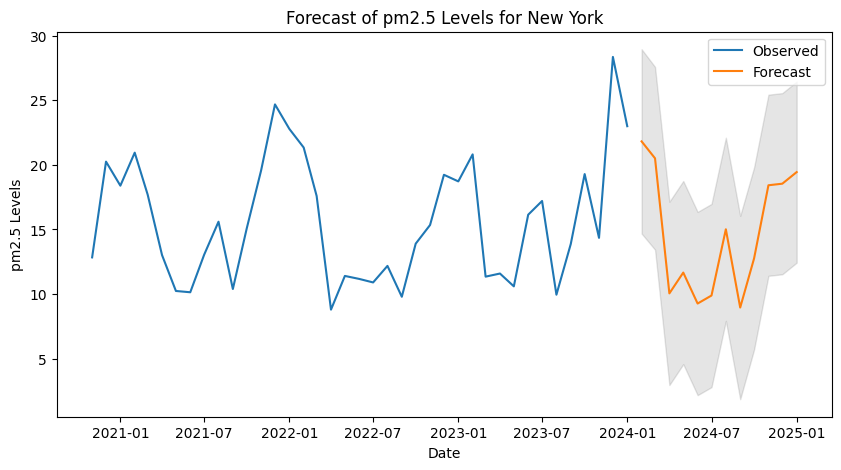

In [96]:
# Ejecución de la función
column_to_forecast = 'pm2.5'  # se puede cambiar a 'pm2.5' o 'pm10' según sea necesario
forecast_new_york(df_monthly, column_to_forecast)

## Para new york pm 10

C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eduardo\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


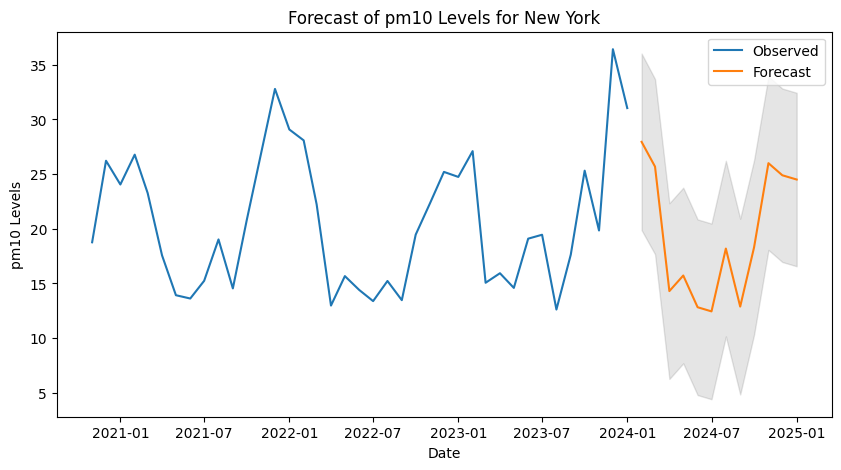

In [97]:
# Ejecución de la función
column_to_forecast = 'pm10'  # se puede cambiar a 'pm2.5' o 'pm10' según sea necesario
forecast_new_york(df_monthly, column_to_forecast)